In [0]:
!git clone -l -s -b master git://github.com/srgynmv/EmoteNN.git emotenn
%cd emotenn

Cloning into 'emotenn'...
remote: Enumerating objects: 20, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 317 (delta 9), reused 14 (delta 5), pack-reused 297
Receiving objects: 100% (317/317), 541.74 KiB | 5.26 MiB/s, done.
Resolving deltas: 100% (181/181), done.
/content/emotenn


In [0]:
%tensorflow_version 2.x
import os
import cv2
import time
import zipfile

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from emotenn import constants as ct, load_utils as lu, train_utils as tu, plot_utils as pu, gen_utils as gu

from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import callbacks
from tensorflow.keras.models import load_model, model_from_json
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, ZeroPadding2D, Convolution2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras import applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Load all datasets

In [0]:
start = time.time()

FER2013 = ct.GDriveFile('16xRMknw-dt13YjvvSPwtpSlYXsE73awF', os.path.join(ct.DATASETS_DIR, 'FER2013.zip'))
EXPW = ct.GDriveFile('1iKBcurf4zcJ2CNEOBB6BTfReTYz-ctmD', os.path.join(ct.DATASETS_DIR, 'EXPW.zip'))
JAFFE = ct.GDriveFile('1GQBTlVXsaKqtgrkTvuVIu9pF4ND2VKLC', os.path.join(ct.DATASETS_DIR, 'JAFFE.zip'))
images_dir = os.path.join(ct.UNPACKED_DIR, 'images')

for dataset in [FER2013, EXPW, JAFFE]:
    lu.download_file_from_google_drive(dataset, exist_ok=True)
    with zipfile.ZipFile(dataset.path, 'r') as archive:
        archive.extractall(images_dir)

end = time.time()
print(f'Elapsed: {end-start:.1f} seconds')

Elapsed: 237.20313549041748


## Train our CNN from scratch

In [0]:
strategy = tu.get_distribution_strategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


In [0]:
def build_cnn():
    with strategy.scope():
        model = Sequential()

        model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(48, 48, 3), data_format='channels_last', kernel_regularizer=l2(0.01)))
        model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
        model.add(Dropout(0.5))

        model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
        model.add(BatchNormalization())
        model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
        model.add(Dropout(0.5))

        model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'))
        model.add(BatchNormalization())
        model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
        model.add(Dropout(0.5))

        model.add(Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same'))
        model.add(BatchNormalization())
        model.add(Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
        model.add(Dropout(0.5))

        model.add(Flatten())

        model.add(Dense(512, activation='relu'))
        model.add(Dropout(0.4))
        model.add(Dense(256, activation='relu'))
        model.add(Dropout(0.4))
        model.add(Dense(128, activation='relu'))
        model.add(Dropout(0.5))

        model.add(Dense(7, activation='softmax'))
        model.compile(loss=categorical_crossentropy,
                      optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7),
                      metrics=['accuracy'])
    return model

In [0]:
def get_callbacks(model_name):
    path = os.path.join(ct.CHECKPOINTS_DIR, model_name + '-{epoch:02d}-{val_accuracy:.2f}.h5')
    os.makedirs(ct.CHECKPOINTS_DIR, exist_ok=True)

    return [
        # callbacks.EarlyStopping(verbose=1, patience=10, monitor='val_accuracy', mode='max')
        # callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=10, verbose=0, mode='max', epsilon=0.0001, cooldown=0, min_lr=0)
        callbacks.ModelCheckpoint(path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')                 
    ]

In [0]:
batch_size = 128
target_img_size = 48, 48
data_gen = ImageDataGenerator(validation_split=0.1)
train_data = data_gen.flow_from_directory(images_dir,
                                          classes=ct.CLASS_NAMES,
                                          target_size=target_img_size,
                                          batch_size=batch_size,
                                          subset='training')
valid_data = data_gen.flow_from_directory(images_dir,
                                          classes=ct.CLASS_NAMES,
                                          target_size=target_img_size,
                                          batch_size=batch_size,
                                          subset='validation')

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:173: UserWarning: Using ".tiff" files with multiple bands will cause distortion. Please verify your output.
  warnings.warn('Using ".tiff" files with multiple bands '


Found 115106 images belonging to 7 classes.
Found 12787 images belonging to 7 classes.


In [0]:
epochs = 10
cb = get_callbacks('cnn_base')

model = build_cnn()
train_history = model.fit(x=train_data,
                          steps_per_epoch=train_data.samples // train_data.batch_size,
                          validation_data=valid_data,
                          validation_steps=valid_data.samples // valid_data.batch_size,
                          callbacks=cb,
                          epochs=epochs)

Epoch 1/10
899/899 [==============================] - ETA: 0s - accuracy: 0.3255 - loss: 1.7403
Epoch 00001: val_accuracy improved from -inf to 0.31392, saving model to /content/emotenn/results/checkpoints/cnn_base-01-0.31.h5
899/899 [==============================] - 171s 190ms/step - accuracy: 0.3255 - loss: 1.7403 - val_accuracy: 0.3139 - val_loss: 1.6942
Epoch 2/10
899/899 [==============================] - ETA: 0s - accuracy: 0.3656 - loss: 1.5718
Epoch 00002: val_accuracy improved from 0.31392 to 0.42057, saving model to /content/emotenn/results/checkpoints/cnn_base-02-0.42.h5
899/899 [==============================] - 170s 189ms/step - accuracy: 0.3656 - loss: 1.5718 - val_accuracy: 0.4206 - val_loss: 1.7583
Epoch 3/10
899/899 [==============================] - ETA: 0s - accuracy: 0.4980 - loss: 1.3992
Epoch 00003: val_accuracy improved from 0.42057 to 0.54570, saving model to /content/emotenn/results/checkpoints/cnn_base-03-0.55.h5
899/899 [==============================] - 169

Run 10 more epochs...

In [0]:
train_history_p2 = model.fit(x=train_data,
                             steps_per_epoch=train_data.samples // train_data.batch_size,
                             validation_data=valid_data,
                             validation_steps=valid_data.samples // valid_data.batch_size,
                             callbacks=cb,
                             epochs=20,
                             initial_epoch=10)

Epoch 11/20
899/899 [==============================] - ETA: 0s - accuracy: 0.6391 - loss: 1.0501
Epoch 00011: val_accuracy did not improve from 0.62461
899/899 [==============================] - 168s 187ms/step - accuracy: 0.6391 - loss: 1.0501 - val_accuracy: 0.6163 - val_loss: 1.1278
Epoch 12/20
899/899 [==============================] - ETA: 0s - accuracy: 0.6469 - loss: 1.0263
Epoch 00012: val_accuracy improved from 0.62461 to 0.63299, saving model to /content/emotenn/results/checkpoints/cnn_base-12-0.63.h5
899/899 [==============================] - 168s 187ms/step - accuracy: 0.6469 - loss: 1.0263 - val_accuracy: 0.6330 - val_loss: 1.1015
Epoch 13/20
899/899 [==============================] - ETA: 0s - accuracy: 0.6538 - loss: 1.0078
Epoch 00013: val_accuracy did not improve from 0.63299
899/899 [==============================] - 168s 187ms/step - accuracy: 0.6538 - loss: 1.0078 - val_accuracy: 0.6057 - val_loss: 1.2224
Epoch 14/20
899/899 [==============================] - ETA: 0

Run 10 more epochs...

In [0]:
train_history_p3 = model.fit(x=train_data,
                             steps_per_epoch=train_data.samples // train_data.batch_size,
                             validation_data=valid_data,
                             validation_steps=valid_data.samples // valid_data.batch_size,
                             callbacks=cb,
                             epochs=30,
                             initial_epoch=20)

Epoch 21/30
899/899 [==============================] - ETA: 0s - accuracy: 0.6889 - loss: 0.9025
Epoch 00021: val_accuracy did not improve from 0.65598
899/899 [==============================] - 166s 184ms/step - accuracy: 0.6889 - loss: 0.9025 - val_accuracy: 0.6382 - val_loss: 1.1127
Epoch 22/30
899/899 [==============================] - ETA: 0s - accuracy: 0.6909 - loss: 0.8967
Epoch 00022: val_accuracy did not improve from 0.65598
899/899 [==============================] - 165s 183ms/step - accuracy: 0.6909 - loss: 0.8967 - val_accuracy: 0.6474 - val_loss: 1.0773
Epoch 23/30
899/899 [==============================] - ETA: 0s - accuracy: 0.6939 - loss: 0.8825
Epoch 00023: val_accuracy did not improve from 0.65598
899/899 [==============================] - 165s 184ms/step - accuracy: 0.6939 - loss: 0.8825 - val_accuracy: 0.6410 - val_loss: 1.1173
Epoch 24/30
899/899 [==============================] - ETA: 0s - accuracy: 0.6991 - loss: 0.8719
Epoch 00024: val_accuracy did not improve 

## Evaluate the model

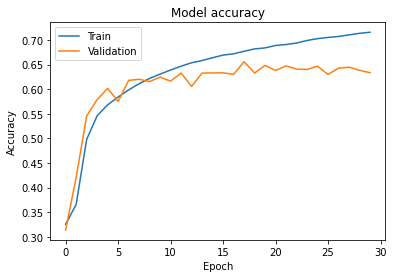

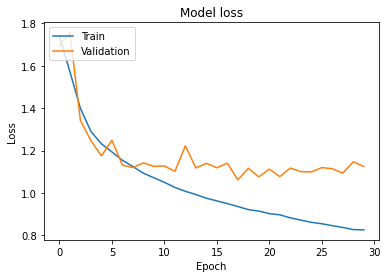

In [0]:
aggregated_history = {'accuracy': [], 'val_accuracy': [], 'loss': [], 'val_loss': []}
for history in [train_history, train_history_p2, train_history_p3]:
    for key in aggregated_history.keys():
        aggregated_history[key] += history.history[key]
pu.plot_model_history(aggregated_history)

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:173: UserWarning: Using ".tiff" files with multiple bands will cause distortion. Please verify your output.
  warnings.warn('Using ".tiff" files with multiple bands '


Found 12787 images belonging to 7 classes.
99/99 [==============================] - 19s 187ms/step - accuracy: 0.6319 - loss: 1.1405
Dataset accuracy: 63.19%


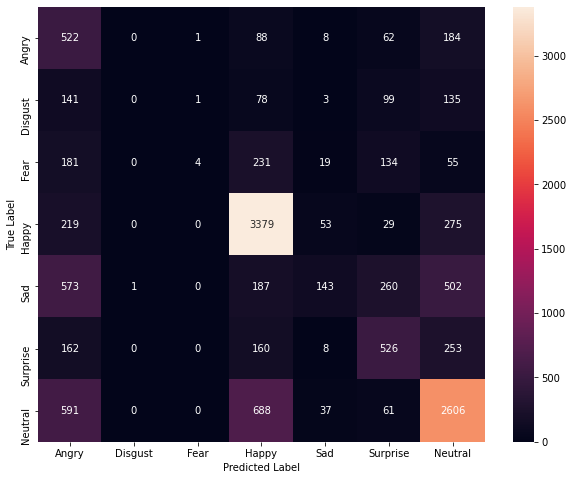

In [0]:
test_data = data_gen.flow_from_directory(images_dir,
                                         classes=ct.CLASS_NAMES,
                                         target_size=target_img_size,
                                         batch_size=batch_size,
                                         subset='validation',
                                         shuffle=False)

score = model.evaluate(x=test_data, steps=test_data.samples // test_data.batch_size)
print("Dataset {}: {:.2f}%".format(model.metrics_names[1], score[1] * 100))

predictions = model.predict(x=test_data, steps=test_data.samples // test_data.batch_size)
Y_pred = np.rint(predictions)
Y_true = test_data.classes[:len(Y_pred)]

from sklearn.metrics import confusion_matrix
import seaborn as sns

confusion_mtx = confusion_matrix(Y_true, np.argmax(Y_pred, axis=1)) 
plt.figure(figsize=(10,8))
sns.heatmap(confusion_mtx, annot=True, fmt='d', xticklabels=ct.CLASS_NAMES, yticklabels=ct.CLASS_NAMES)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()